<a href="https://colab.research.google.com/github/skreddypalvai/s3Ho4t5iMRItcowM/blob/main/MonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MonReader**




*  The primary objective of this project is to use deep learning methodologies, specifically Convolutional Neural Networks (CNNs), to achieve a high level of precision in discerning whether a given image page is being flipped or not.

Importing necessary libraries

In [ ]:
from keras.src.utils.tf_utils import set_random_seed
#reproducebility
set_random_seed(42)

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Input, TimeDistributed, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight

In [ ]:
# loadind the respective image path files and setting the image size as 120*120
training_path = '/content/drive/MyDrive/images/training'
testing_path = '/content/drive/MyDrive/images/testing'
image_size = (120,120)

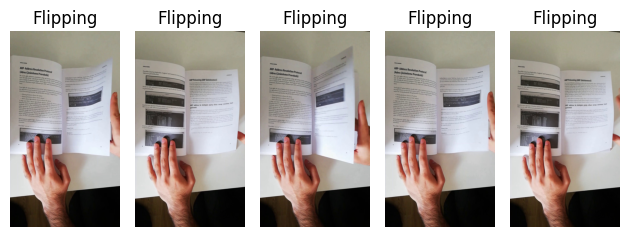

In [ ]:
# loading flip and notflip image subfolders using training folder path
flipped_images = []
not_flipped_images = []
for subdir in os.listdir(training_path):
    subdir_path = os.path.join(training_path, subdir)
    if os.path.isdir(subdir_path):
        image_list = os.listdir(subdir_path)
        for i in range(len(image_list)):
            if i < 5 and subdir == 'flip':
                flipped_images.append(os.path.join(subdir, image_list[i]))
            elif i < 5 and subdir == 'notflip':
                not_flipped_images.append(os.path.join(subdir, image_list[i]))
# Visualizing  flipping images
for i in range(5):
    plt.subplot(2, 5, i + 1)
    img_path = os.path.join(training_path, flipped_images[i])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title('Flipping')
    plt.axis('off')
plt.tight_layout()
plt.show()

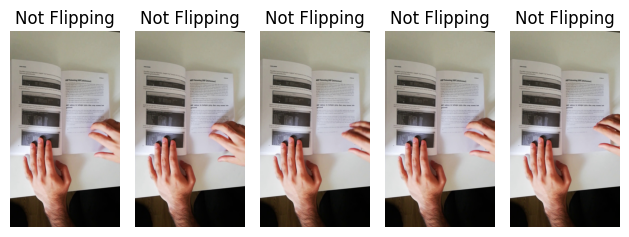

In [ ]:
# Visualizing not_flipping images
for i in range(5):
    plt.subplot(2, 5, i + 6)
    img_path = os.path.join(training_path, not_flipped_images[i])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title('Not Flipping')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#We wil use the tensorflow's function 'image dataset from directory' to directly prepare the data for training a CNN
# For training set
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    validation_split=0.2,
    subset="training",
    label_mode='int',
    batch_size=32,
    image_size=image_size,
    class_names=['notflip', 'flip'],
    seed=42
)
# for validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    validation_split=0.2,
    subset="validation",
    label_mode='int',
    batch_size=32,
    image_size=image_size,
    class_names=['notflip', 'flip'],
    seed=42
)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.


In [ ]:
# For the testing set
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    testing_path,
    label_mode='int',
    batch_size=32,
    image_size=image_size,
    class_names=['notflip', 'flip'],
)

Found 597 files belonging to 2 classes.


We will be using the test set for evaluating the model.

Successfully prepared the image data for modeling, ensuring it is formatted correctly and ready for training.

In [ ]:
#clearing all the unwanted resources before building the CNN architecture
import tensorflow.keras.backend as K
K.clear_session()

####  Convolution Neural Networks(CNN):

In [ ]:
# Creating a Sequential model
model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(*image_size, 3)), # adding rescaling layer to rescale the images
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),                                             # adding maxpooling to reduce the params
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),                                                              # adding dropout layer for regularization
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),    # avoiding overfitting issue's
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        3

In [ ]:
#using necessary callbacks by monitoring val_loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('weight.hdf5', monitor='val_loss', save_best_only=True)

In [ ]:
# Train the model
training = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
60/60 [==============================] - 201s 3s/step - loss: 1.1350 - accuracy: 0.5627 - val_loss: 0.7095 - val_accuracy: 0.5649 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
60/60 [==============================] - 44s 706ms/step - loss: 0.6285 - accuracy: 0.6938 - val_loss: 0.7206 - val_accuracy: 0.6004 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 43s 692ms/step - loss: 0.4910 - accuracy: 0.8140 - val_loss: 0.3491 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 49s 765ms/step - loss: 0.3438 - accuracy: 0.9007 - val_loss: 0.2876 - val_accuracy: 0.9435 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 45s 707ms/step - loss: 0.3119 - accuracy: 0.9216 - val_loss: 0.2590 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 44s 703ms/step - loss: 0.2603 - accuracy: 0.9363 - val_loss: 0.1865 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 43s 698ms/step - loss: 0.2255 - accuracy: 0.9535 - val_loss: 0.1946 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 8/20
60/60 [==============================] - 44s 696ms/st

In [ ]:
# saving model weights and can load whenever we want to
model.save_weights('weight.hdf5')

In [ ]:
# saving the model
model.save('Mode.hdf5')

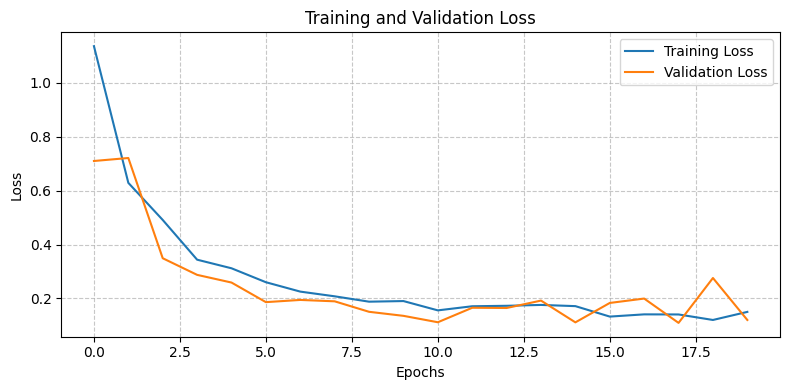

In [ ]:
train_loss = training.history['loss']
val_loss = training.history['val_loss']
train_accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
# monitoring train and val loss
fig, ax1 = plt.subplots(figsize=(8, 4))
# Plot training and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()
plt.tight_layout()
plt.show()

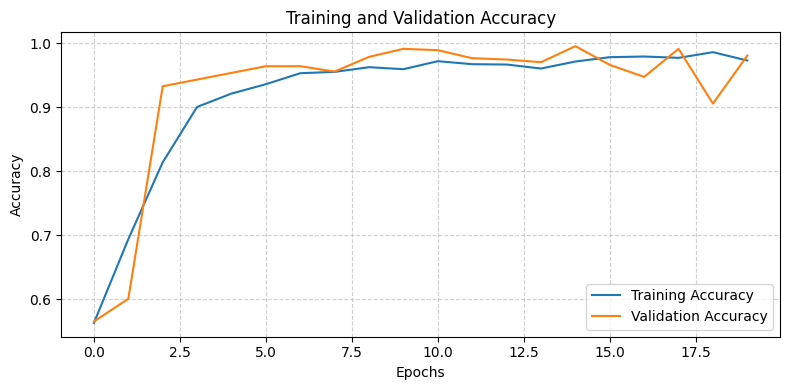

In [ ]:
#monitoring train and val accuracy
fig, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()
plt.tight_layout()
plt.show()

**Model Evaluation**

In [ ]:
# using the test set(unseen data) for evaluating the model
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

19/19 [==============================] - 6s 211ms/step - loss: 0.1315 - accuracy: 0.9765
Test Loss: 0.131466805934906
Test Accuracy: 0.9765493869781494


In [ ]:
# displaying the confusion matrix
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels
for images, labels in test_dataset:
    predictions = model(images).numpy() > 0.5
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)
# Build confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

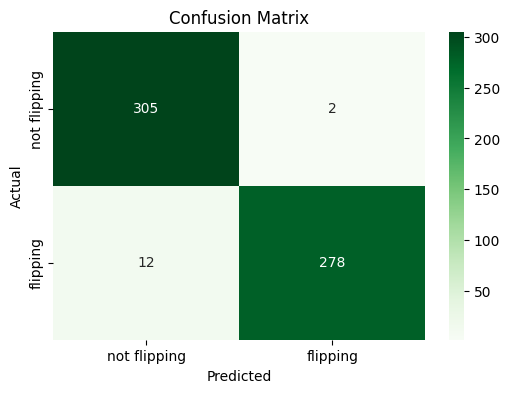

In [ ]:
class_names = ['not flipping', 'flipping']
# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# calculating precision, recall and F1 scores
report2 = classification_report(y_true, y_pred, target_names=class_names)
print(f"Classification Report:\n{report2}")

Classification Report:
              precision    recall  f1-score   support

not flipping       0.96      0.99      0.98       307
    flipping       0.99      0.96      0.98       290

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



We can confirm that model attained a high F1 score - 98%.

In [ ]:
# loading the saved model and using it to predict the images
loaded_model = tf.keras.models.load_model('Mode.hdf5')

Predicting the test_set images :

1/1 [==============================] - 0s 28ms/step


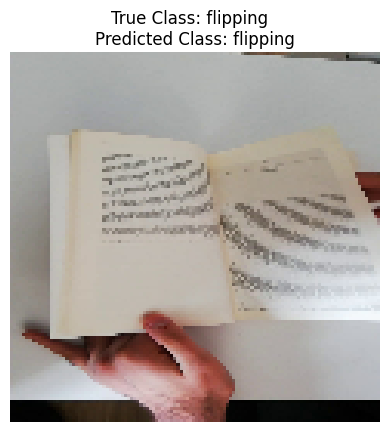

1/1 [==============================] - 0s 31ms/step


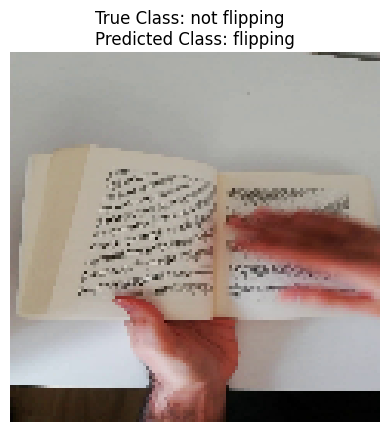

1/1 [==============================] - 0s 46ms/step


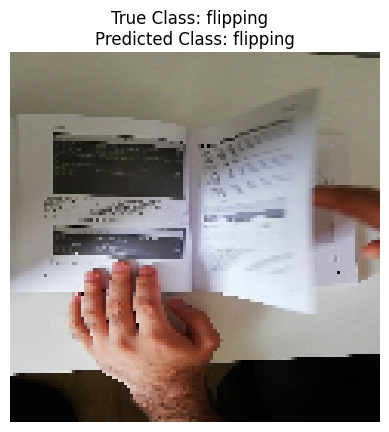

1/1 [==============================] - 0s 44ms/step


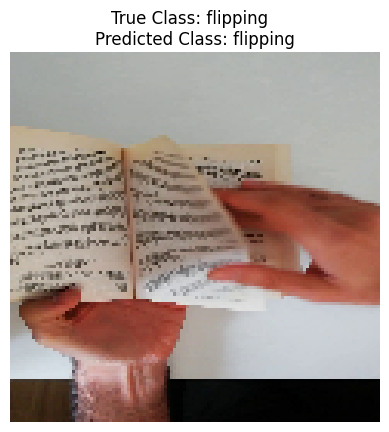

1/1 [==============================] - 0s 59ms/step


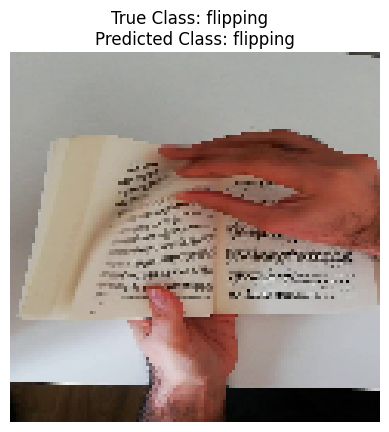

In [ ]:
# Convert test_dataset to a list
test_images = []
test_labels = []
for images, labels in test_dataset:
    test_images.append(images)
    test_labels.append(labels)
# Concatenate the list of images and labels
test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)
# 5 random indices
random_indices = np.random.choice(len(test_images), size=5, replace=False)
# Predict and display the respective images
for idx in random_indices:
    random_image = test_images[idx]
    random_label = test_labels[idx]
    # Reshaping and preprocessing the random image
    random_image = tf.image.resize(random_image, image_size)
    random_image = tf.expand_dims(random_image, axis=0) / 255.0
    # Predicting whether the random image is being flipped or not
    prediction = loaded_model.predict(random_image)[0][0]
    predicted_class = class_names[int(round(prediction))]
    # Display the image
    plt.imshow(random_image[0].numpy())
    plt.axis('off')
    plt.title(f"True Class: {class_names[int(random_label.numpy())]}  \nPredicted Class: {predicted_class}")
    plt.show()

Upon careful examination, it becomes apparent that among the set of five images provided, an impressive four have been accurately identified as depicting a flipping action, showcasing the model's commendable predictive capabilities.